##### Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime
import seaborn as sns
import scipy.optimize
from IPython.display import display, display_markdown
from numpy.lib.stride_tricks import sliding_window_view

In [3]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

# Experiment

## Load data

In [4]:
curls_df = pd.read_csv("./data/sam/Curls_3x10_7kg-2024-01-25_16-55-30/TotalAcceleration.csv")
squat_df = pd.read_csv("./data/sam/Squats_3x8_7kg-2024-01-25_17-00-38/TotalAcceleration.csv")
curls_df

,time,seconds_elapsed,y,z,x,hypothesis
0,1.706202e+18,0.252757,-7.177817,6.464345,0.991199,NaN
1,1.706202e+18,0.274439,-7.551312,6.133945,1.216254,NaN
2,1.706202e+18,0.290274,-7.771579,5.315128,1.273715,NaN
3,1.706202e+18,0.306591,-8.087613,5.238513,0.900220,NaN
4,1.706202e+18,0.316342,-8.240842,5.722142,1.297657,NaN
...,...,...,...,...,...,...
3308,1.706202e+18,36.236247,1.015141,7.556100,7.144298,NaN
3309,1.706202e+18,36.246292,0.588974,7.513005,7.407660,NaN
3310,1.706202e+18,36.256083,0.378284,7.235278,6.971915,NaN
3311,1.706202e+18,36.266168,0.756568,7.163452,6.296751,NaN


## Trim data to relevant periods

Data is trimmed so that it starts at the beginning of the first rep and ends at the end of the last rep.

|Exercise|Reps|Weight|
|-|-|-|
|Curls|10|7kg dumbbells|
|Squats|8|7kg dumbbells|

In [5]:
# Plot x, y and z values on a line for curl_df
def plot_accelerometer(df):
    fig = plt.figure(figsize=(50, 5))  
    plt.subplot(1, 3, 1)
    plt.ylabel("Accelerometer $m/s^2$")
    plt.xlabel("Time elapsed (s)")
    plt.plot(df["seconds_elapsed"], df["x"], label="x")
    plt.plot(df["seconds_elapsed"], df["y"], label="y")
    ax = plt.plot(df["seconds_elapsed"], df["z"], label="z")

def plot_accelerometer_hyp(df):
    fig = plt.figure(figsize=(50, 5))  
    plt.subplot(1, 3, 1)
    plt.ylabel("Accelerometer $m/s^2$")
    plt.xlabel("Time elapsed (s)")
    plt.plot(df["seconds_elapsed"], df["x"], label="x")
    plt.plot(df["seconds_elapsed"], df["y"], label="y")
    ax = plt.plot(df["seconds_elapsed"], df["z"], label="z")

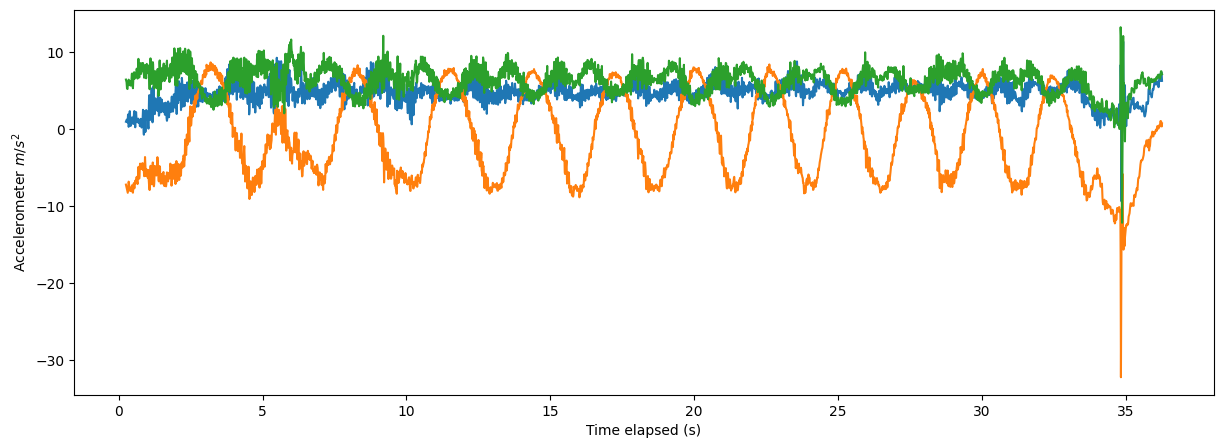

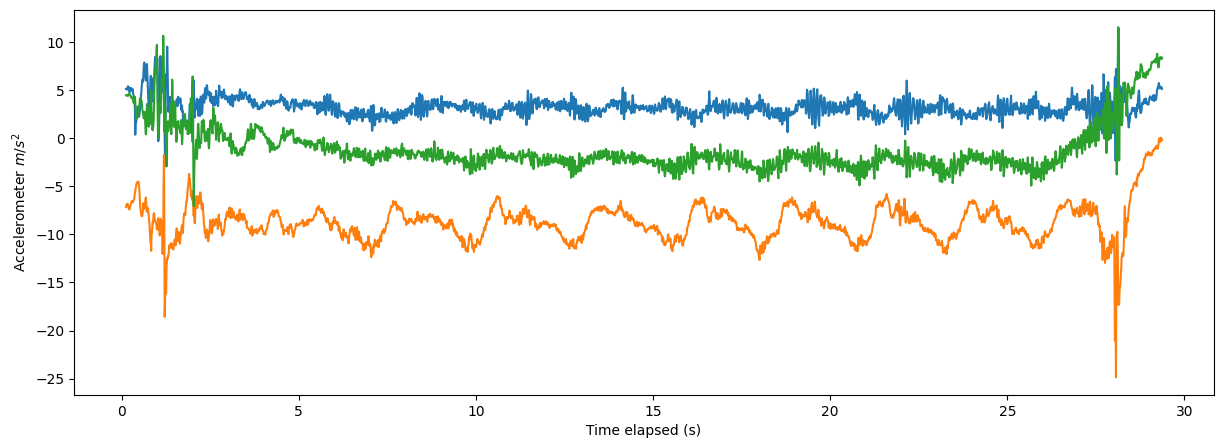

In [6]:
plot_accelerometer(curls_df)
plot_accelerometer(squat_df)

In [7]:
# Trim curls to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
curls_df_start = curls_df[curls_df["seconds_elapsed"] == 7.0367890625].index[0]
curls_df_end = curls_df[curls_df["seconds_elapsed"] == 33.48751904296875].index[0]
curls_df_trim = curls_df.iloc[curls_df_start:curls_df_end, :]

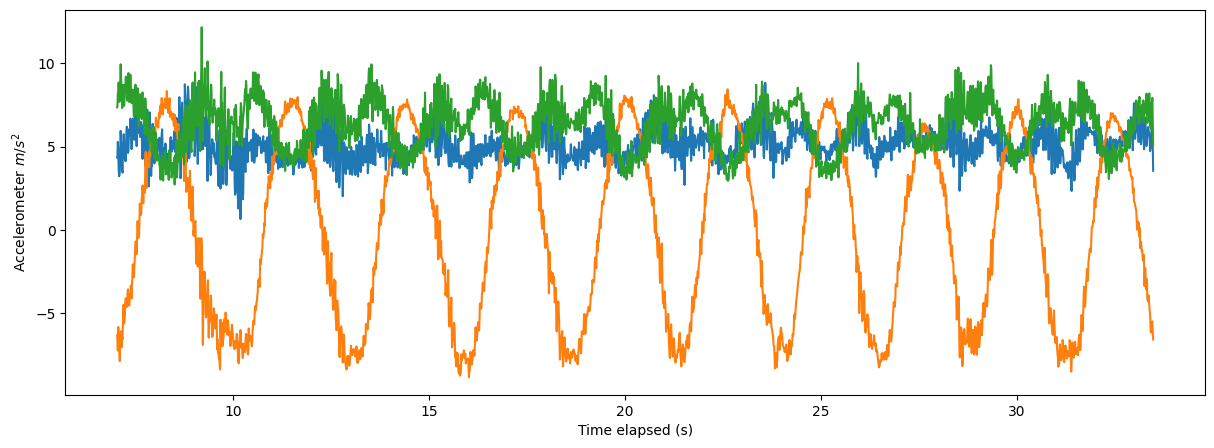

In [8]:
plot_accelerometer(curls_df_trim)

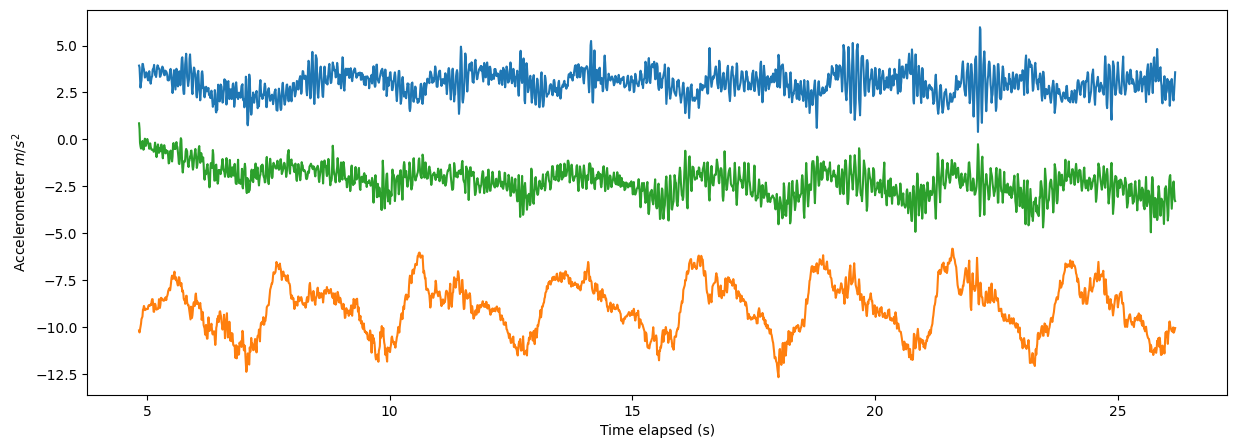

In [9]:
# Trim squats to remove the picking up of weights at the beginning of
# the set and the putting down at the end of the set
squat_df_start = squat_df[squat_df["seconds_elapsed"] == 4.837999267578125].index[0] #4.83
squat_df_end = squat_df[squat_df["seconds_elapsed"] == 26.19851220703125].index[0] #26.19
squat_df_trim = squat_df.iloc[squat_df_start:squat_df_end, :]
plot_accelerometer(squat_df_trim)

## Label data

Periods in the data representing certain motions are manually marked with the appropriate hypothesis.

|Exercise|Part|Hypothesis|
|-|-|-|
|Curls|Raising movement|$\mathcal{H}_0$|
|Curls|Lowering movement|$\mathcal{H}_0$|
|Curls|Motionless period between reps|$\mathcal{H}_0$|
|Squats|Raising movement|$\mathcal{H}_1$|
|Squats|Lowering movement|$\mathcal{H}_1$|
|Squats|Motionless period between reps|$\mathcal{H}_0$|

### Set true hypotheses on trimmed data

#### Curls
This looks stupid but might have value as a control case?

In [10]:
curls_df_trim.loc[:, 'hypothesis'] = 0
# ax = plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["hypothesis"])

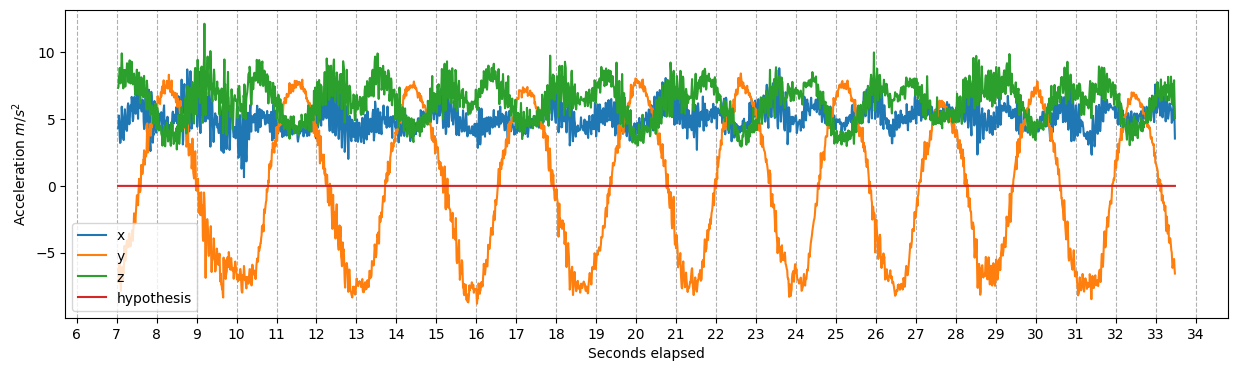

In [11]:
# Plot accelerometer data and hypothesis on the same graph
plt.figure(figsize=(15, 4))
plt.xlabel("Seconds elapsed")
plt.ylabel("Acceleration $m/s^2$")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["x"], label="x")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["y"], label="y")
plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["z"], label="z")
ax = plt.plot(curls_df_trim["seconds_elapsed"], curls_df_trim["hypothesis"], label="hypothesis")
plt.legend()
plt.grid(visible=True, axis="x", linestyle="--")
a= plt.xticks(np.arange(6, 35, 1))

#### Squats

In [12]:
squat_df_trim["seconds_elapsed"] >= 0

464     True
465     True
466     True
467     True
468     True
        ... 
2389    True
2390    True
2391    True
2392    True
2393    True
Name: seconds_elapsed, Length: 1930, dtype: bool

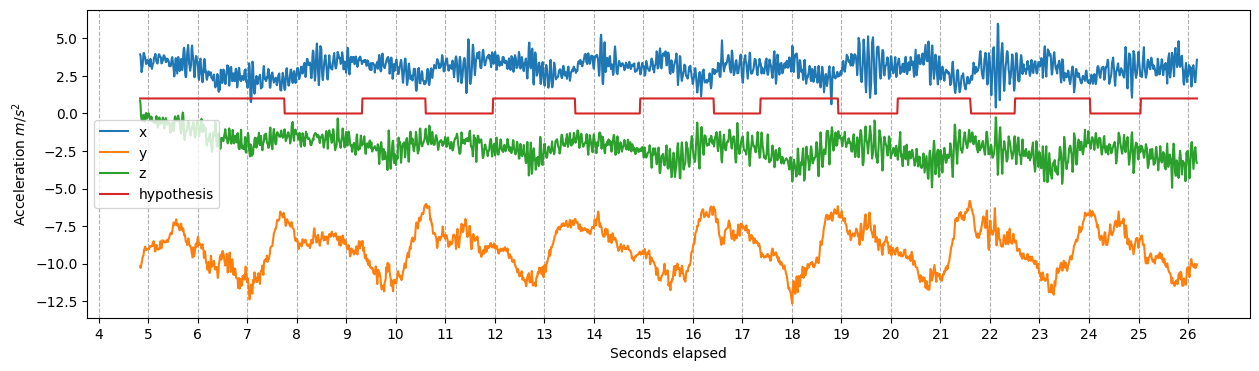

In [13]:
# Motionless end   - idx 0
# Bottom of rep 1  - 7.03787s - H1 - 7.037873779296875
# Top of rep 1     - 7.75819s - H1 - 7.75818505859375
# Motionless end 1 - 9.32852s - H0 - 9.328517822265624
# Bottom of rep 2  - 9.76746s - H1 - 9.7674619140625
# Top of rep 2     - 10.5975s - H1 - 10.597513916015625
# Motionless end 2 - 11.9576s - H0 - 11.957637939453125
# Bottom of rep 3  - 12.7275s - H1 - 12.727472900390625
# Top of rep 3     - 13.618s  - H1 - 13.618012939453125
# Motionless end 3 - 14.9384s - H0 - 14.93835205078125
# Bottom of rep 4  - 15.8475s - H1 - 15.8475068359375
# Top of rep 4     - 16.4283s - H1 - 16.428326904296874
# Motionless end 4 - 17.368s  - H0 - 17.36797705078125
# Bottom of rep 5  - 18.2379s - H1 - 18.237943115234376
# Top of rep 5     - 18.938s  - H1 - 18.938011962890624
# Motionless end 5 - 20.1391s - H0 - 20.139137939453125
# Bottom of rep 6  - 21.0387s - H1 - 21.03868115234375
# Top of rep 6     - 21.6189s - H1 - 21.618908935546877
# Motionless end 6 - 22.5000s - H0 - 22.507530029296873
# Bottom of rep 6  - 23.2380s - H1 - 23.2380419921875
# Top of rep 7     - 24.0281s - H1 - 24.028087158203125
# Motionless end 7 - 25.0486s - H0 - 25.048609130859376
# Bottom of rep 8  - 25.7177s - H1 - 25.71772119140625
# Top of rep 8     - 26.7175s - H1 - 26.717465087890623
# Motionless end 8 - 27.5377s - H0 - 27.537717041015625

conds = [
    (squat_df_trim["seconds_elapsed"] >= 0.0)                & (squat_df_trim["seconds_elapsed"] < 7.037873779296875),
    (squat_df_trim["seconds_elapsed"] >= 7.037873779296875) & (squat_df_trim["seconds_elapsed"] < 7.75818505859375),
    (squat_df_trim["seconds_elapsed"] >= 7.75818505859375) & (squat_df_trim["seconds_elapsed"] < 9.328517822265624),
    (squat_df_trim["seconds_elapsed"] >= 9.328517822265624) & (squat_df_trim["seconds_elapsed"] < 9.7674619140625),
    (squat_df_trim["seconds_elapsed"] >= 9.7674619140625) & (squat_df_trim["seconds_elapsed"] < 10.597513916015625),
    (squat_df_trim["seconds_elapsed"] >= 10.597513916015625) & (squat_df_trim["seconds_elapsed"] < 11.957637939453125),
    (squat_df_trim["seconds_elapsed"] >= 11.957637939453125) & (squat_df_trim["seconds_elapsed"] < 12.727472900390625),
    (squat_df_trim["seconds_elapsed"] >= 12.727472900390625) & (squat_df_trim["seconds_elapsed"] < 13.618012939453125),
    (squat_df_trim["seconds_elapsed"] >= 13.618012939453125) & (squat_df_trim["seconds_elapsed"] < 14.93835205078125),
    (squat_df_trim["seconds_elapsed"] >= 14.93835205078125) & (squat_df_trim["seconds_elapsed"] < 15.8475068359375),
    (squat_df_trim["seconds_elapsed"] >= 15.8475068359375) & (squat_df_trim["seconds_elapsed"] < 16.428326904296874),
    (squat_df_trim["seconds_elapsed"] >= 16.428326904296874) & (squat_df_trim["seconds_elapsed"] < 17.36797705078125),
    (squat_df_trim["seconds_elapsed"] >= 17.36797705078125) & (squat_df_trim["seconds_elapsed"] < 18.237943115234376),
    (squat_df_trim["seconds_elapsed"] >= 18.237943115234376) & (squat_df_trim["seconds_elapsed"] < 18.938011962890624),
    (squat_df_trim["seconds_elapsed"] >= 18.938011962890624) & (squat_df_trim["seconds_elapsed"] < 20.139137939453125),
    (squat_df_trim["seconds_elapsed"] >= 20.139137939453125) & (squat_df_trim["seconds_elapsed"] < 21.03868115234375),
    (squat_df_trim["seconds_elapsed"] >= 21.03868115234375) & (squat_df_trim["seconds_elapsed"] < 21.618908935546877),
    (squat_df_trim["seconds_elapsed"] >= 21.618908935546877) & (squat_df_trim["seconds_elapsed"] < 22.507530029296873),
    (squat_df_trim["seconds_elapsed"] >= 22.507530029296873) & (squat_df_trim["seconds_elapsed"] < 23.2380419921875),
    (squat_df_trim["seconds_elapsed"] >= 23.2380419921875)& (squat_df_trim["seconds_elapsed"] < 24.028087158203125),
    (squat_df_trim["seconds_elapsed"] >= 24.028087158203125) & (squat_df_trim["seconds_elapsed"] < 25.048609130859376),
    (squat_df_trim["seconds_elapsed"] >= 25.048609130859376) & (squat_df_trim["seconds_elapsed"] < 25.71772119140625),
    (squat_df_trim["seconds_elapsed"] >= 25.71772119140625) & (squat_df_trim["seconds_elapsed"] < 26.717465087890623),
    (squat_df_trim["seconds_elapsed"] >= 26.717465087890623) & (squat_df_trim["seconds_elapsed"] < 27.537717041015625),
]

values = [1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0,1,1,0]
true_hyps = np.select(conds, values)
squat_df_trim.loc[:, 'hypothesis'] = true_hyps

# Plot accelerometer data and hypothesis on the same graph
plt.figure(figsize=(15, 4))
plt.xlabel("Seconds elapsed")
plt.ylabel("Acceleration $m/s^2$")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["x"], label="x")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["y"], label="y")
plt.plot(squat_df_trim["seconds_elapsed"], squat_df_trim["z"], label="z")
ax = plt.plot(squat_df_trim["seconds_elapsed"], np.select(conds, values), label="hypothesis")
plt.legend()
plt.grid(visible=True, axis="x", linestyle="--")
a= plt.xticks(np.arange(4, 27, 1))

## Compute test statistics for data

In [14]:
def SSM(vector):
    return np.array(
        [
            [0, -vector[2], vector[1]],
            [vector[2], 0, -vector[1]],
            [vector[1], vector[0], 0],
        ]
    )


def calc_min_ev(alpha_beta_gamma: tuple[3], y):
    """Calculate the minimum eigenvalue
    This function will be minimized on the direction of gravity

    y is a sliding window about a certain measurement"""
    u_g = np.array(alpha_beta_gamma)
    g = 9.81

    M = np.zeros((3, 3))
    for y_k in y:  # [x, y, z]
        measurement = y_k + (g * u_g)
        M += SSM(measurement).T * SSM(measurement)

    if np.isnan(np.ravel(M)).any():
        return 9999999999999999999

    eigvs, _ = np.linalg.eig(M)
    return min(eigvs)

In [15]:
def optimise_u_g(y, guess=(0.1, 0.1, 0.1)):
    """Use scipy to optimise the alpha and beta for the best min eig
    
    TODO WRITE IN REPORT HOW JOHAN WAS WRONG - THE PROBLEM IS 3D NOT 2D"""
    res = scipy.optimize.minimize(
        fun=calc_min_ev,
        x0=guess,
        args=(y,),
        constraints=[{"type": "eq", "fun": lambda x: np.sum(np.array(x)**2) - 1}],
        method="trust-constr",
    )
    return res

In [16]:
def decide_on_hypothesis(test_statistics, gamma):
    """Decide on hypothesis at each point."""
    return test_statistics > gamma

def calc_true_positives(decisions, true_hyps):
    """Calculate the proportion of H1 (translational motion) that were correctly identified."""
    return np.mean((decisions == 1) & (true_hyps == 1))

def calc_false_positives(decisions, true_hyps):
    """Calculate the proportion of H0 (no translational motion) that were incorrectly identified as H1."""
    return np.mean((decisions == 1) & (true_hyps == 0))

def calc_true_negatives(decisions, true_hyps):
    """Calculate the proportion of H0 (no translational motion) that were correctly identified."""
    return np.mean((decisions == 0) & (true_hyps == 0))

def calc_false_negatives(decisions, true_hyps):
    """Calculate the proportion of H1 (translational motion) that were incorrectly identified as H0."""
    return np.mean((decisions == 0) & (true_hyps == 1))

def plot_hypotheses(x, hypotheses, s=None):
    plt.xlabel("Seconds elapsed (s)")
    plt.ylabel("Hypothesis")
    plt.yticks([0, 1])
    plt.ylim(-0.1, 1.1)
    ax = plt.scatter(x, hypotheses, s=s)
    return ax

In [17]:
def measurement_window(measurements, n, stride=1):
    """
    Create sliding windows of size 'n' from the measurements data.

    Parameters:
    measurements (DataFrame): The input measurements data.
    n (int): The size of the sliding window.
    stride (int, optional): The stride value for the sliding window. Defaults to 1.

    Returns:
    ndarray: The sliding windows of size 'n' from the measurements data.
    """
    x_sw = sliding_window_view(measurements["x"].to_numpy(), n)
    y_sw = sliding_window_view(measurements["y"].to_numpy(), n)
    z_sw = sliding_window_view(measurements["z"].to_numpy(), n)

    # Combine x, y and z into 3D vectors for each measurement in the sliding window
    sw = np.stack((x_sw, y_sw, z_sw), axis=-1)
    return sw[::stride]

# sw_100[k] is the kth window of 100 measurements
# sw_100[k][j] is the jth measurement in the kth window
# sw_100[k][j][i] is the ith coordinate of the jth measurement in the kth window

In [18]:
def min_min_evs(windows):
    Ts = []  # min min eigs

    for window in windows:
        res = optimise_u_g(window)
        min_min_ev = res.fun
        Ts.append(min_min_ev)

    return Ts

### What do the test statistics (minimum minimum eigenvalues) look like?

#### Calculate min min eigenvalues

In [19]:
squat_window_stride = 10
squat_window_size = 100
curl_window_stride = 10
curl_window_size = 100

In [20]:
# squat_Ts = min_min_evs(measurement_window(squat_df_trim, squat_window_size, stride=squat_window_stride))
squat_Ts = pd.read_csv("data/sam/squat_Ts_stride_10_size_100.csv").to_numpy().flatten()

In [21]:
# curl_Ts = min_min_evs(measurement_window(curls_df_trim_t, curl_window_size, stride=curl_window_stride))
curl_Ts = pd.read_csv("./data/sam/curl_Ts_stride_10_size_100.csv").to_numpy().flatten()

In [22]:
# Create a copy of both dataframes with stride and trimmed to the correct length
squat_df_trim_s = squat_df_trim[::squat_window_stride]
curls_df_trim_s = curls_df_trim[::curl_window_stride]
# Trim to length of Ts
squat_df_trim_s = squat_df_trim_s[:len(squat_Ts)]
curls_df_trim_s = curls_df_trim_s[:len(curl_Ts)]

print("Squats")
print(squat_df_trim_s.shape)
print(pd.Series(squat_Ts).shape)

print()

print("Curls")
print(curls_df_trim_s.shape)
print(pd.Series(curl_Ts).shape)

Squats
(184, 6)
(184,)

Curls
(231, 6)
(231,)


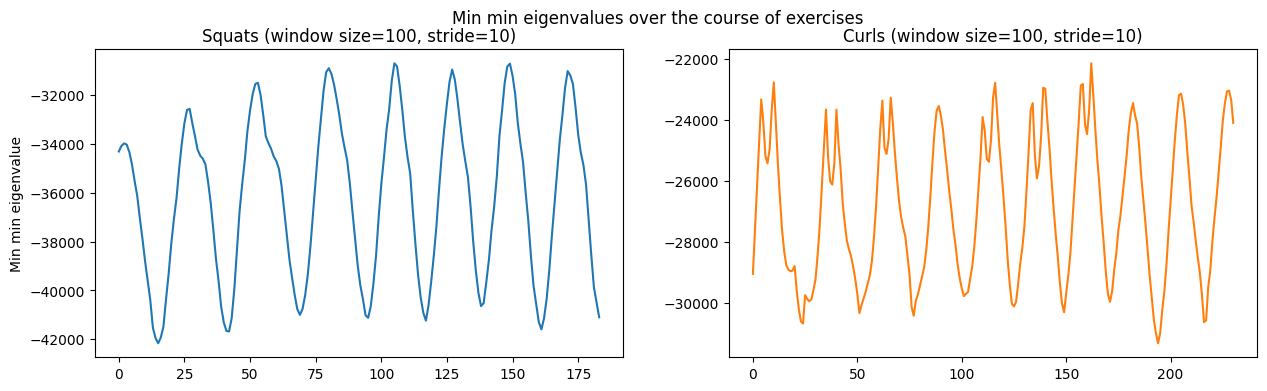

In [23]:
# Exploratory eigenvalue plot
plt.figure(figsize=(15, 4))
plt.suptitle("Min min eigenvalues over the course of exercises")

plt.subplot(1, 2, 1)
plt.title(f"Squats (window size={squat_window_size}, stride={squat_window_stride})")
plt.ylabel("Min min eigenvalue")
ax = pd.Series(squat_Ts).plot(color="tab:blue")

plt.subplot(1, 2, 2)
plt.title(f"Curls (window size={curl_window_size}, stride={curl_window_stride})")
ax = pd.Series(curl_Ts).plot(color="tab:orange")

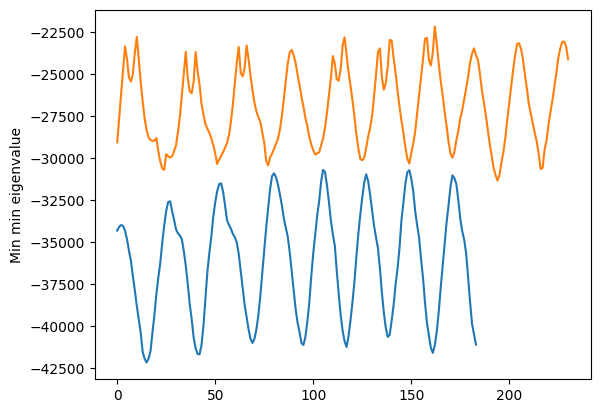

In [24]:
plt.ylabel("Min min eigenvalue")
ax = pd.Series(squat_Ts).plot()
ax = pd.Series(curl_Ts).plot()

Clear separation visible

### Deciding on hypotheses

In [25]:
def side_by_side_hyps(x, y1, y2, left, right, s=1):
    """Plot two sets of hypotheses side by side."""
    fig = plt.figure(figsize=(15, 2.5))
    fig.supylabel("Hypothesis")

    plt.subplot(2, 1, 1)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 1))
    plt.grid(axis="x", linestyle="--")
    ax1 = plt.scatter(x, y1, s=s, color="tab:blue")

    plt.subplot(2, 1, 2)
    plt.yticks([0, 1])
    plt.xlim(left, right)
    plt.ylim(-0.1, 1.1)
    plt.xticks(np.arange(left, right, 1))
    plt.grid(axis="x", linestyle="--")
    ax2 = plt.scatter(x, y2, s=s, color="tab:orange")
    plt.xlabel("Seconds elapsed (s)")
    return ax1, ax2

In [26]:
def grid_search_gammas(Ts, true_hyps, left, right, step):
    """Grid search for the best gamma."""
    gammas = np.arange(left, right, step)
    true_pos_arr = []
    false_pos_arr = []
    true_neg_arr = []
    false_neg_arr = []
    hyp_sets = []

    for gamma in gammas:
        decisions = decide_on_hypothesis(Ts, gamma)
        true_pos_arr.append(calc_true_positives(decisions, true_hyps))
        false_pos_arr.append(calc_false_positives(decisions, true_hyps))
        true_neg_arr.append(calc_true_negatives(decisions, true_hyps))
        false_neg_arr.append(calc_false_negatives(decisions, true_hyps))

        hyp_sets.append(decisions)

    return gammas, true_pos_arr, false_pos_arr, true_neg_arr, false_neg_arr, hyp_sets

### Grid search gammas for best hypothesis decisions

#### Squats

In [27]:
# Grid search thresholds
squat_gamma_lower = -50_000
squat_gamma_upper = -20_000
squat_gamma_step = 1

(
    squat_gammas,
    squat_true_pos_arr,
    squat_false_pos_arr,
    squat_true_neg_arr,
    squat_false_neg_arr,
    squat_hyp_sets,
) = grid_search_gammas(
    squat_Ts,
    squat_df_trim_s["hypothesis"].values,
    squat_gamma_lower,
    squat_gamma_upper,
    squat_gamma_step,
)

#### Curls

In [28]:
# Grid search thresholds
curl_gamma_lower = -35_000
curl_gamma_upper = -20_000
curl_gamma_step = 1
(
    curl_gammas,
    curl_true_pos_arr,
    curl_false_pos_arr,
    curl_true_neg_arr,
    curl_false_neg_arr,
    curl_hyp_sets,
) = grid_search_gammas(
    curl_Ts,
    curls_df_trim_s["hypothesis"].values,
    curl_gamma_lower,
    curl_gamma_upper,
    curl_gamma_step,
)

### Plot classification metrics

In [29]:
def plot_class_metrics(gammas, true_pos_arr, false_pos_arr, true_neg_arr, false_neg_arr):
    """Plot the classification metrics."""
    plt.subplot(2, 2, 1)
    plt.title("True positives")
    plt.xlabel("$ \gamma $")
    plt.ylabel("Proportion")
    plt.plot(gammas, true_pos_arr, color="tab:blue")
    plt.subplot(2, 2, 2)
    plt.title("False positives")
    plt.xlabel("$ \gamma $")
    plt.ylabel("Proportion")
    plt.plot(gammas, false_pos_arr, color="tab:orange")
    plt.subplot(2, 2, 3)
    plt.title("True negatives")
    plt.xlabel("$ \gamma $")
    plt.ylabel("Proportion")
    plt.plot(gammas, true_neg_arr, color="tab:green")
    plt.subplot(2, 2, 4)
    plt.title("False negatives")
    plt.xlabel("$ \gamma $")
    plt.ylabel("Proportion")
    plt.plot(gammas, false_neg_arr, color="tab:red")
    plt.tight_layout()

#### Squats

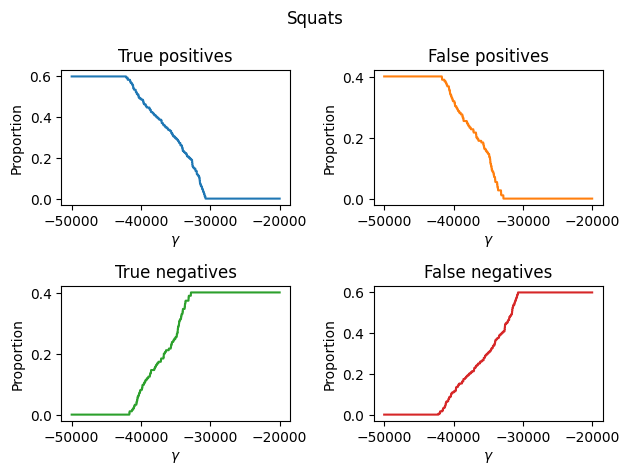

In [30]:
# Plot metrics for squats
t = plt.suptitle("Squats")
plot_class_metrics(
    squat_gammas,
    squat_true_pos_arr,
    squat_false_pos_arr,
    squat_true_neg_arr,
    squat_false_neg_arr,
)

Text(0, 0.5, 'True positive rate')

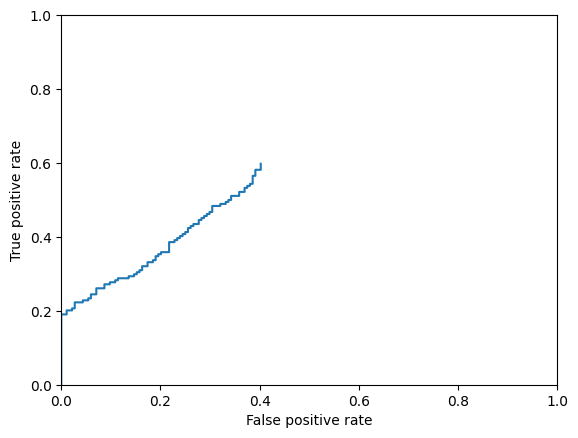

In [31]:
# True positives vs false positives for squats
plt.plot(squat_false_pos_arr, squat_true_pos_arr, label="Curls")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

/tmp/ipykernel_15291/2734297483.py:2: RuntimeWarning: invalid value encountered in divide
  squat_precisions = np.array(squat_true_pos_arr) / (


(-0.05, 1.05)

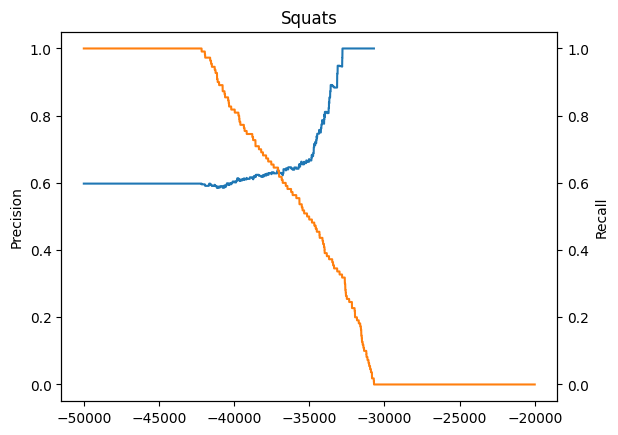

In [32]:
# Precision & recall
squat_precisions = np.array(squat_true_pos_arr) / (
    np.array(squat_true_pos_arr) + np.array(squat_false_pos_arr)
)
squat_recalls = np.array(squat_true_pos_arr) / (
    np.array(squat_true_pos_arr) + np.array(squat_false_neg_arr)
)
f1_scores = 2 * (squat_precisions * squat_recalls) / (squat_precisions + squat_recalls)
plt.title("Squats")
plt.ylabel("Precision")
plt.ylim(-0.05, 1.05)
plt.twinx()
plt.xlabel("$ \gamma $")
plt.plot(squat_gammas, squat_precisions, color="tab:blue")
plt.ylabel("Recall")
plt.plot(squat_gammas, squat_recalls, color="tab:orange")
plt.ylim(-0.05, 1.05)

#### Curls

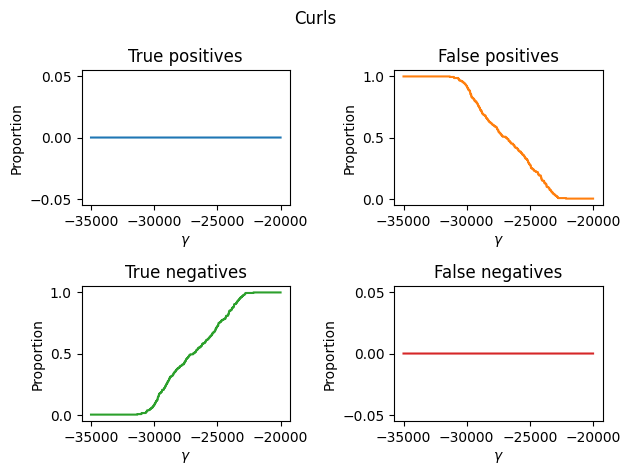

In [33]:
# Plot metrics for curls
t = plt.suptitle("Curls")
plot_class_metrics(
    curl_gammas,
    curl_true_pos_arr,
    curl_false_pos_arr,
    curl_true_neg_arr,
    curl_false_neg_arr,
)

### Plot hypotheses

#### Squats

0.40217391304347827


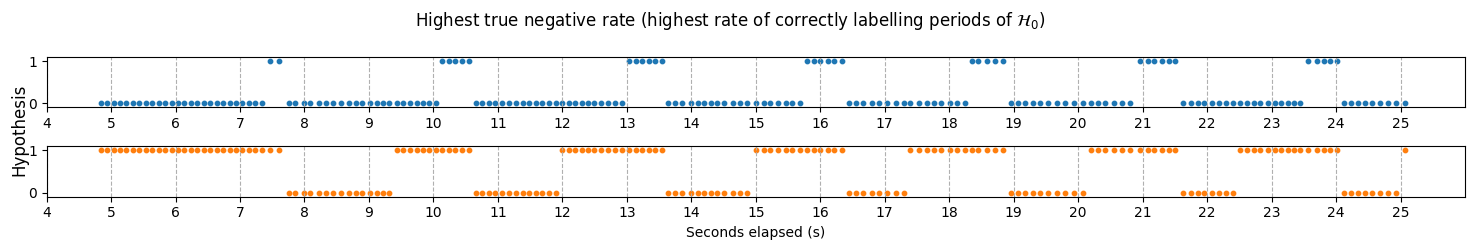

In [44]:
# Highest true negative rate
side_by_side_hyps(
    squat_df_trim_s["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_true_neg_arr)],
    squat_df_trim_s["hypothesis"],
    4,
    26,
    s=10
)
plt.suptitle("Highest true negative rate (highest rate of correctly labelling periods of $\mathcal{H}_0$)")
plt.tight_layout()
print(max(squat_true_neg_arr))

0.40217391304347827


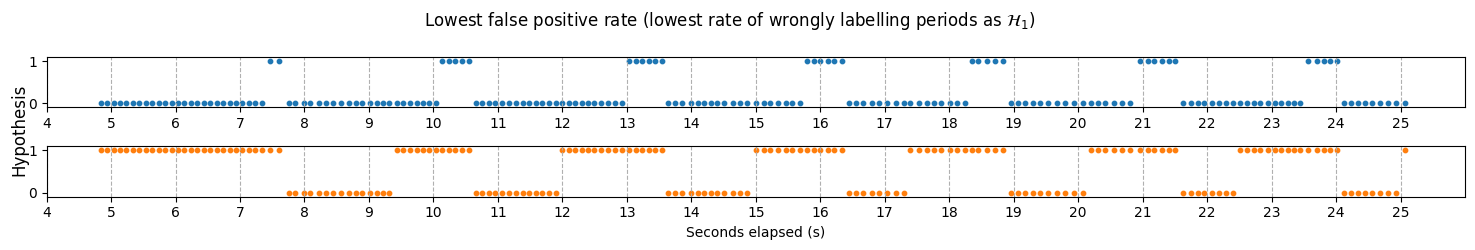

In [45]:
# Lowest false positive rate
side_by_side_hyps(
    squat_df_trim_s["seconds_elapsed"],
    squat_hyp_sets[np.argmin(squat_false_pos_arr)],
    squat_df_trim_s["hypothesis"],
    4,
    26,
    s=10
)
plt.suptitle("Lowest false positive rate (lowest rate of wrongly labelling periods as $\mathcal{H}_1$)")
plt.tight_layout()
print(max(squat_false_pos_arr))

0.5978260869565217


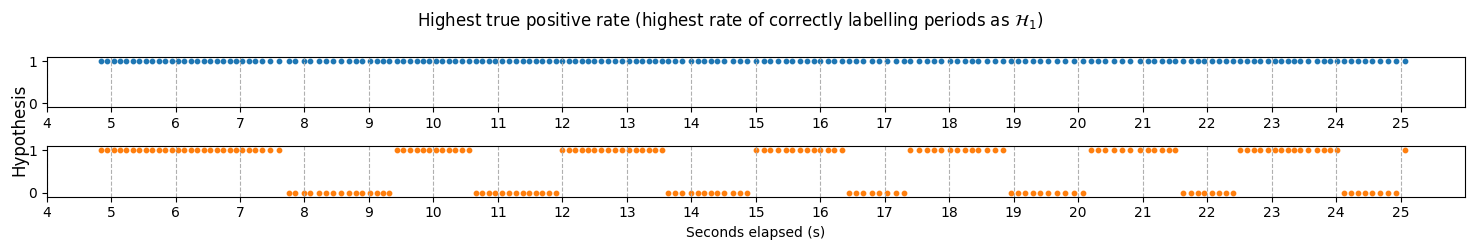

In [46]:
# Highest true positive rate
side_by_side_hyps(
    squat_df_trim_s["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_true_pos_arr)],
    squat_df_trim_s["hypothesis"],
    4,
    26,
    s=10
)
plt.suptitle("Highest true positive rate (highest rate of correctly labelling periods as $\mathcal{H}_1$)")
plt.tight_layout()
print(max(squat_true_pos_arr))

0.5978260869565217


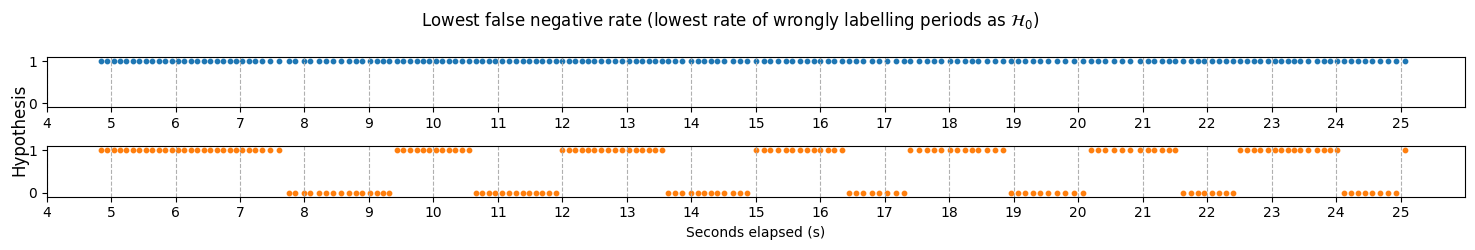

In [47]:
# Lowest false negative rate
side_by_side_hyps(
    squat_df_trim_s["seconds_elapsed"],
    squat_hyp_sets[np.argmin(squat_false_neg_arr)],
    squat_df_trim_s["hypothesis"],
    4,
    26,
    s=10
)
plt.suptitle("Lowest false negative rate (lowest rate of wrongly labelling periods as $\mathcal{H}_0$)")
plt.tight_layout()
print(max(squat_false_neg_arr))

1.0


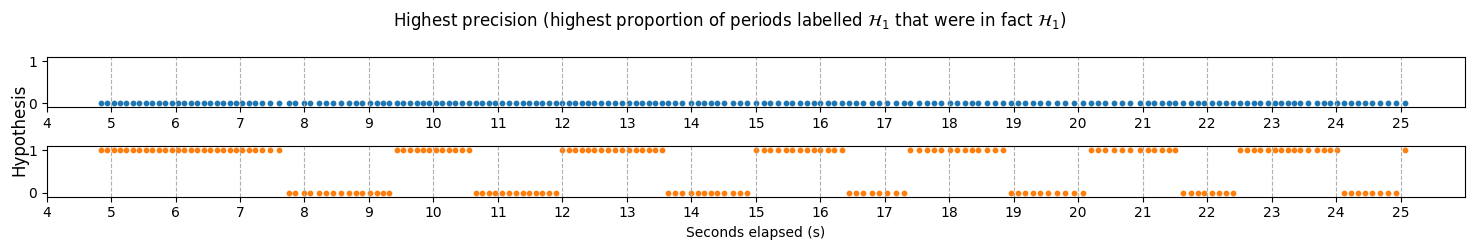

In [43]:
# Highest precision
side_by_side_hyps(
    squat_df_trim_s["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_precisions)],
    squat_df_trim_s["hypothesis"],
    4,
    26,
    s=10
)
plt.suptitle("Highest precision (highest proportion of periods labelled $\mathcal{H}_1$ that were in fact $\mathcal{H}_1$)")
plt.tight_layout()
print(max(squat_precisions))

1.0


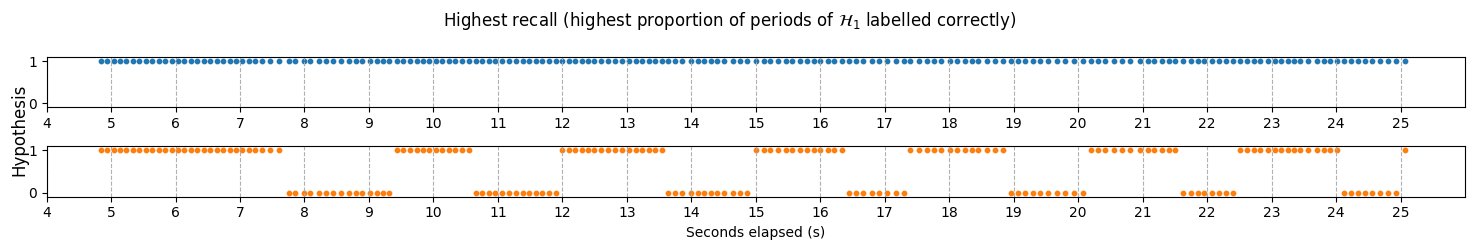

In [48]:
# Highest recall
side_by_side_hyps(
    squat_df_trim_s["seconds_elapsed"],
    squat_hyp_sets[np.argmax(squat_recalls)],
    squat_df_trim_s["hypothesis"],
    4,
    26,
    s=10
)
# how many of the H1s were correctly identified as H1
plt.suptitle("Highest recall (highest proportion of periods of $\mathcal{H}_1$ labelled correctly)")
plt.tight_layout()
print(max(squat_recalls))

#### Interesting takeaways
- The classification with the **lowest false positive** rate is identical to the one with the **highest true negative** rate.
    - These make a pretty good attempt at classifying.
- The classification with the **highest true positive** rate is identical to the one with the **lowest false negative** rate.
    - These just guess $ \mathcal{H}_1 $ for every measurement window.
- The classification with the **highest precision** just guesses $\mathcal{H}_0$ every time.
    - The highest precision is 1.0 

#### Curls

# To do
- more window sizes
- ROC curve
- still data as translation ?

- extend - third hypothesis for not moving at all
- Try with more motions to see if separation still present?

# Draft sending deadline: a week before (<ins>24th April</ins>)